In [1]:
# Modified from the CAMB Python example notebook
# https://camb.readthedocs.io/en/latest/CAMBdemo.html

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams['agg.path.chunksize'] = 10000
res_dpi = 300
ext = 'png'
outfolder = 'paperplots_160'

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


import numpy as np
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


Using CAMB 1.3.5 installed at /Users/bicep/opt/anaconda3/envs/py39/lib/python3.9/site-packages/camb


In [2]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
#Numbers from https://arxiv.org/pdf/1807.06209.pdf Table.1.
#Neutrino mass is a bit messy, see section 7.5.1.
#r is set to 0.01
pars.set_cosmology(H0=67.4, ombh2=0.0224, omch2=0.120, mnu=0.1, omk=0.001, tau=0.054)
pars.InitPower.set_params(As=2.100e-9, ns=0.965, r=0.01)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [3]:
#calculate results for these parameters
pars.WantTensors=True
pars.max_l_tensor = 2500
results = camb.get_results(pars)

In [4]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


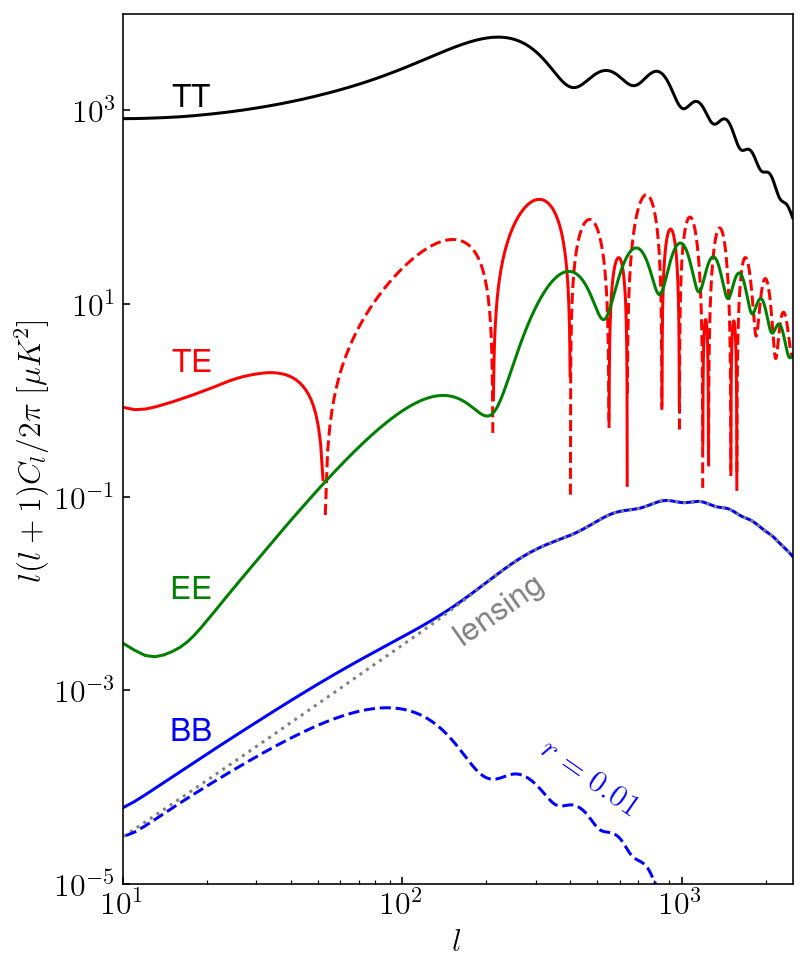

In [6]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['tensor']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(1,1, figsize = (6,8))
ax.plot(ls,totCL[:,0], color='k') # lensed TT in black
ax.plot(ls,np.where(totCL[:,3]>0,totCL[:,3],np.nan), color='r') # lensed TE in red
ax.plot(ls,np.where(totCL[:,3]<0,-totCL[:,3],np.nan), color='r',linestyle='--') # lensed TE in red
ax.plot(ls,totCL[:,1], color='g') # lensed EE in green

ax.plot(ls,totCL[:,2], color='b') # lensed BB in blue
ax.plot(ls,totCL[:,2]-unlensedCL[:,2], color='grey',linestyle='dotted')
ax.plot(ls,unlensedCL[:,2], color='b', linestyle='--') # unlensed BB in blue dash


ax.tick_params(axis='both', which='both', direction='in', labelsize=16)

ax.set_xlim([10,2500])
ax.set_ylim([1e-5,1e4])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$l(l+1)C_l/2\pi~[\mu K^2]$', fontsize=16)
ax.set_xlabel(r'$l$', fontsize=16)

ax.text(15, 1100, r'TT', fontsize=16)
ax.text(15, 2, r'TE', color='r', fontsize=16)
ax.text(15, 0.009, r'EE', color='g', fontsize=16)
ax.text(15, 3e-4, r'BB', color='b', fontsize=16)
ax.text(300, 0.5e-4, r'$r=0.01$', rotation=-35, color='b', fontsize=16)
ax.text(150, 3e-3, r'lensing', rotation=35, color='grey', fontsize=16)

plt.savefig('./CAMB_spectra_all_r001.pdf',format='pdf')
